In [3]:
import sys
sys.path.append('..')

In [4]:
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

/home/ubuntu/research-1/medical-gpt-interpretability/ENV/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
models = {
    "BioGPT": {
        "model": AutoModelForCausalLM.from_pretrained("microsoft/biogpt"),
        "tokenizer": AutoTokenizer.from_pretrained("microsoft/biogpt")
    },
    "BioGPT-PubMedQA": {
        "model": AutoModelForCausalLM.from_pretrained("microsoft/BioGPT-Large-PubMedQA"),
        "tokenizer": AutoTokenizer.from_pretrained("microsoft/BioGPT-Large-PubMedQA")
    },
    "GPT2": {
        "model": AutoModelForCausalLM.from_pretrained("openai-community/gpt2"),
        "tokenizer": AutoTokenizer.from_pretrained("openai-community/gpt2")
    },
    "GPT2-XL":{
        "model": AutoModelForCausalLM.from_pretrained("openai-community/gpt2-xl"),
        "tokenizer": AutoTokenizer.from_pretrained("openai-community/gpt2-xl")
    }
}

In [6]:
data_path = "../data/ori_pqal.json"
with open(data_path, "r") as f:
    data = json.load(f)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

for model_info in models.values():
    model_info["model"].to(device)
    model_info["model"].eval()

In [26]:
def format_prompt(question, context):
    return f"Based on the following context, determine the answer as 'yes', 'no', or 'maybe'. \n\nContext: {context} \n\nQuestion: {question} The answer to this question is "

In [29]:
def evaluate_exact_match_accuracy(data, models, with_context=False):
    results = {}
    for model_name, model_info in models.items():
        model = model_info["model"]
        tokenizer = model_info["tokenizer"]
        correct = 0

        print(f"Evaluating {model_name}")
        for id, entry in data.items():
            question = entry["QUESTION"]
            if with_context:
                contexts = entry["CONTEXTS"]
                combined_context = " ".join(contexts)
            true_answer = entry["final_decision"].strip().lower()

            if with_context:
                prompt = format_prompt(question, combined_context)
            else:
                prompt = format_prompt(question, "")

            inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
            with torch.no_grad():
                outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

            logits = outputs.logits[0, -1, :]

            # get max probability token
            predicted_index = torch.argmax(logits).item()
            predicted_token = tokenizer.decode(predicted_index).strip().lower()
            print(f"Predicted: {predicted_token}, True: {true_answer}")
            if predicted_token == true_answer:
                correct += 1


        # Calculate accuracy
        accuracy = correct / len(data) * 100
        results[model_name] = accuracy
    
    return results

In [30]:
results = evaluate_exact_match_accuracy(data, models, with_context=False)

Evaluating BioGPT
Predicted: not, True: yes
Predicted: ', True: no
Predicted: ', True: yes
Predicted: ', True: no
Predicted: ', True: yes
Predicted: ', True: yes
Predicted: ', True: maybe
Predicted: ', True: no
Predicted: yes, True: no
Predicted: ', True: yes
Predicted: ', True: yes
Predicted: ', True: no
Predicted: yes, True: yes
Predicted: yes, True: no
Predicted: not, True: yes
Predicted: ', True: yes
Predicted: not, True: yes
Predicted: ', True: yes
Predicted: ', True: yes
Predicted: ', True: yes
Predicted: :, True: yes
Predicted: yes, True: yes
Predicted: ', True: yes
Predicted: not, True: yes
Predicted: ', True: yes
Predicted: yes, True: no
Predicted: yes, True: yes
Predicted: ', True: maybe
Predicted: ', True: yes
Predicted: yes, True: yes
Predicted: yes, True: no
Predicted: yes, True: maybe
Predicted: not, True: no
Predicted: yes, True: yes
Predicted: not, True: yes
Predicted: not, True: no
Predicted: yes, True: no
Predicted: ', True: no
Predicted: :, True: yes
Predicted: not, 

In [31]:
print(results)

{'BioGPT': 13.0, 'BioGPT-PubMedQA': 51.300000000000004, 'GPT2': 0.0, 'GPT2-XL': 0.0}


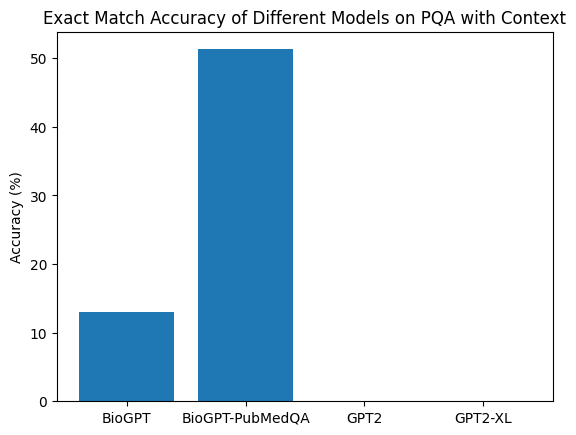

In [32]:
# make bar plot on accuracy
import matplotlib.pyplot as plt

plt.bar(results.keys(), results.values())
plt.ylabel("Accuracy (%)")
plt.title("Exact Match Accuracy of Different Models on PQA with Context")
plt.show()